In [1]:
# install kaggle package
!pip install -q kaggle

In [2]:
# upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abdulmukhit","key":"bd8bd65d3c7d2aed68b03bf13fb03d14"}'}

In [3]:
# buat direktori dan ubah izin
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download -d gauravduttakiit/new-york-taxi

  0% 0.00/54.0k [00:00<?, ?B/s]
100% 54.0k/54.0k [00:00<00:00, 27.4MB/s]


In [6]:
# unzip
!mkdir new-york-taxi
!unzip new-york-taxi.zip -d new-york-taxi
!ls new-york-taxi

Archive:  new-york-taxi.zip
  inflating: new-york-taxi/nyc_taxi.csv  
nyc_taxi.csv


In [7]:
# load dataset
import pandas as pd
df = pd.read_csv('new-york-taxi/nyc_taxi.csv')
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [8]:
# total data
df.shape

(10320, 2)

In [9]:
# data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.4+ KB


In [10]:
df.isnull().sum()

timestamp    0
value        0
dtype: int64

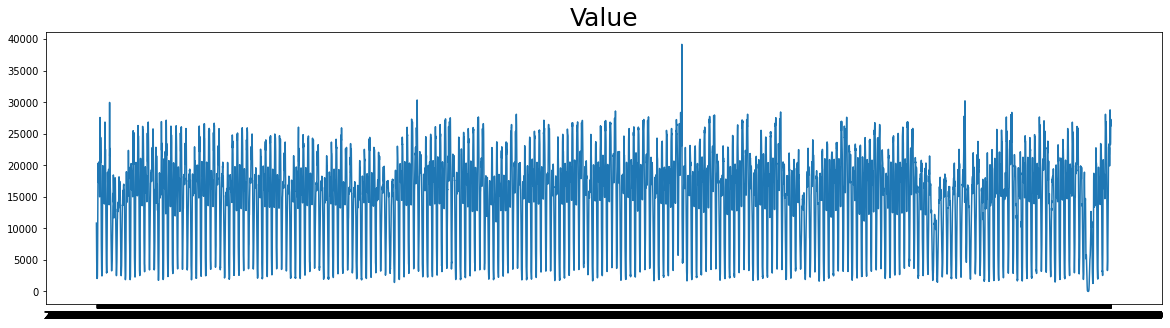

In [11]:
import matplotlib.pyplot as plt
tgl = df['timestamp'].values
val = df['value'].values
 
 
plt.figure(figsize=(20,5))
plt.plot(tgl, val)
plt.title('Value',
          fontsize=25);

In [13]:
df = df.astype({"value": float})

In [14]:
df.dtypes

timestamp     object
value        float64
dtype: object

In [15]:
val = df['value'].values
val

array([10844.,  8127.,  6210., ..., 27309., 26591., 26288.])

In [16]:
val2 = val.reshape(-1,1)

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
min_max_scaler = StandardScaler()
val = min_max_scaler.fit_transform(val2)

In [18]:
val = val.flatten()
val

array([-0.61874487, -1.01029084, -1.28654908, ...,  1.75402085,
        1.65055011,  1.60688488])

In [19]:
val.max()

3.4671966149170586

In [20]:
val.min()

-2.1803172555133887

In [21]:
x = (val.max() - val.min()) * 10/100
print(x)

0.5647513870430447


In [22]:
from sklearn.model_selection import train_test_split
X_latih, X_test = train_test_split(val, test_size=0.2, random_state = 0, shuffle=False)
print(len(X_latih), len(X_test))

8256 2064


In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [25]:
import tensorflow as tf
from keras.layers import Dense, LSTM
latih_set = windowed_dataset(X_latih, window_size=60, batch_size=128, shuffle_buffer=5000)
test_set = windowed_dataset(X_test, window_size=60, batch_size=128, shuffle_buffer=5000)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    ])

In [26]:
# callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< x):
      self.model.stop_training = True
      print("\nMAE model berhenti karna < 10% dari skala data")
callbacks = myCallback()

In [27]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(latih_set, 
                    validation_data=(test_set), 
                    epochs=100, 
                    callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
65/65 [==============================] - 22s 242ms/step - loss: 0.4412 - mae: 0.8179 - val_loss: 0.4679 - val_mae: 0.8406
Epoch 2/100
65/65 [==============================] - 14s 203ms/step - loss: 0.4352 - mae: 0.8104 - val_loss: 0.4620 - val_mae: 0.8335
Epoch 3/100
65/65 [==============================] - 15s 223ms/step - loss: 0.4293 - mae: 0.8032 - val_loss: 0.4566 - val_mae: 0.8269
Epoch 4/100
65/65 [==============================] - 16s 239ms/step - loss: 0.4244 - mae: 0.7969 - val_loss: 0.4510 - val_mae: 0.8195
Epoch 5/100
65/65 [==============================] - 14s 204ms/step - loss: 0.4191 - mae: 0.7898 - val_loss: 0.4455 - val_mae: 0.8119
Epoch 6/100
65/65 [==============================] - 14s 207ms/step - loss: 0.4135 - mae: 0.7826 - val_loss: 0.4395 - val_mae: 0.8039
Epoch 7/100
65/65 [==============================] - 14s 204ms/step - loss: 0.4088 - mae: 0.7754 - val_loss: 0.4337 - val_mae: 0.7960
Epoch 8/100
65/65 [==============================] - 14s 204ms

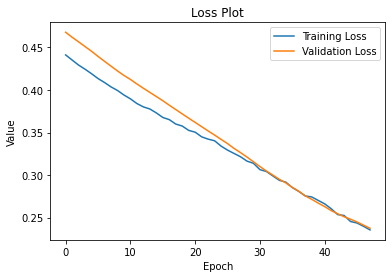

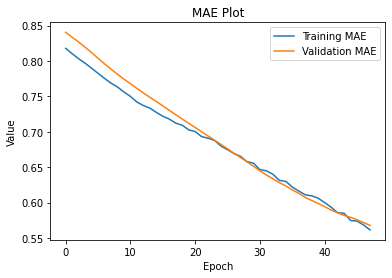

In [37]:
from matplotlib import pyplot as plt
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

#accuracy train & validation
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

#Nama : Abdul Mukhit Murtadho
#Email : muchitabdul11@gmail.com
#No. Registrasi : 1494037162101-2090